In [1]:
from datasets import load_dataset, Features, Sequence, Value, ClassLabel

## Data Statistics (LMI)

In [2]:
mnli = load_dataset("json", data_files="mnli_train.jsonl", split="train")

Using custom data configuration default-03e0588ca815be58
Reusing dataset json (/Users/cecilia/.cache/huggingface/datasets/json/default-03e0588ca815be58/0.0.0/c2d554c3377ea79c7664b93dc65d0803b45e3279000f993c7bfd18937fd7f426)


In [3]:
mnli.features

{'annotator_labels': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'genre': Value(dtype='string', id=None),
 'gold_label': Value(dtype='string', id=None),
 'pairID': Value(dtype='string', id=None),
 'promptID': Value(dtype='string', id=None),
 'sentence1': Value(dtype='string', id=None),
 'sentence1_binary_parse': Value(dtype='string', id=None),
 'sentence1_parse': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'sentence2_binary_parse': Value(dtype='string', id=None),
 'sentence2_parse': Value(dtype='string', id=None)}

In [28]:
from collections import Counter
import math

ds = mnli 

f_wy = Counter()   # joint counts of (word, label)
f_w  = Counter()   # counts of word
f_y  = Counter()   # counts of class (in token-occurrences)

# Iterate and count
for ex in ds:
    y = ex["gold_label"]
    text = (ex["sentence1"] + " " + ex["sentence2"]).lower()
    text = text.replace(".", "")
    tokens = text.split() 
    for w in tokens:
        f_wy[(w, y)] += 1
        f_w[w]     += 1
        f_y[y]     += 1

# Number of unique words in the training set
D = len(f_w)
N = sum(f_y.values())

# Compute LMI for each pair (w,y)
lmi = {}
for (w, y), num in f_wy.items():
    p_joint = num / D
    p_cond = num / f_w[w]
    p_y = f_y[y]/ N
    lmi[(w, y)] = p_joint * math.log(p_cond / p_y)

# Example: top-10 words by LMI for each class
top_by_class = {y: [] for y in f_y}
for (w, y), score in lmi.items():
    top_by_class[y].append((w, score))
for y in top_by_class:
    top_by_class[y].sort(key=lambda x: x[1], reverse=True)
    print(f"\nTop 10 words for class {y}:")
    for w, score in top_by_class[y][:10]:
        print(f"  {w!r}: {score:.2f}")



Top 10 words for class neutral:
  'the': 0.03
  'to': 0.03
  'because': 0.02
  'for': 0.01
  'many': 0.01
  'people': 0.01
  'more': 0.01
  'was': 0.01
  'but': 0.01
  'most': 0.01

Top 10 words for class entailment:
  'a': 0.03
  'of': 0.02
  'that': 0.01
  'can': 0.01
  'and': 0.01
  'some': 0.01
  'by': 0.01
  'you': 0.01
  'an': 0.01
  'be': 0.01

Top 10 words for class contradiction:
  'no': 0.07
  'not': 0.05
  'never': 0.04
  'any': 0.03
  'all': 0.02
  "don't": 0.01
  'only': 0.01
  'nothing': 0.01
  'there': 0.01
  'anything': 0.01


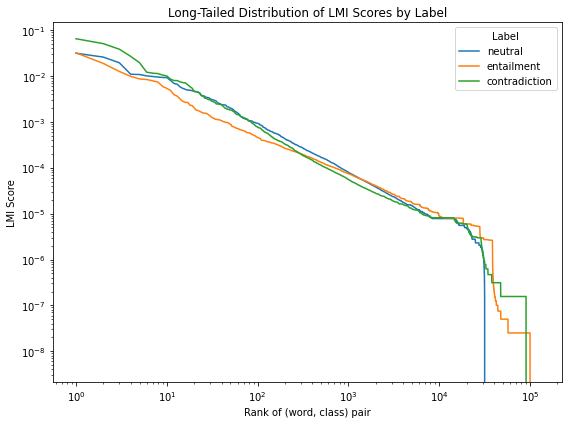

In [29]:
import matplotlib.pyplot as plt

# Assume `lmi` is your dict of {(word, label): score}
# e.g. lmi = {('apple','fruit'):12.3, ('pear','fruit'):8.5, ('apple','company'):5.1, ...}

# 1) Group scores by label
lmi_by_label = {}
for (w, label), score in lmi.items():
    lmi_by_label.setdefault(label, []).append(score)

# 2) Plot each label's distribution
plt.figure(figsize=(8, 6))
for label, scores in lmi_by_label.items():
    sorted_scores = sorted(scores, reverse=True)
    ranks = range(1, len(sorted_scores) + 1)
    plt.loglog(ranks, sorted_scores, label=label)

plt.xlabel("Rank of (word, class) pair")
plt.ylabel("LMI Score")
plt.title("Long-Tailed Distribution of LMI Scores by Label")
plt.legend(title="Label")
plt.tight_layout()
plt.show()


In [1]:
#head words of long-tailed distribution
def lmi_head_words(p=0.05):
    for (w, y), score in lmi.items():
        top_by_class[y].append((w, score))
    for y in top_by_class:
        sorted_words = sorted(top_by_class[y], key=lambda x: x[1], reverse=True)
        
        top_n = max(1, int(len(top_by_class) * p))
        head[y] = set(w for w, v in sorted_words[:top_n])
        
    return head

## BERT model with Integrated Gradients (IG)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
from captum.attr import IntegratedGradients

#bert model finetuned on mnli
model_name = "mrm8488/bert-tiny-finetuned-mnli" 

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

In [ ]:
# 0:entailment, 1:neutral, 2:contradiction
target_label = 1

#take an example
premise = "Your gift is appreciated by each and every student who will benefit from your generosity."
hypothesis = "Hundreds of students will benefit from your generosity."
encoded = tokenizer(premise,hypothesis,
                    return_tensors="pt",
                    truncation=True,
                    max_length=128,
                    padding="max_length")
input_ids      = encoded["input_ids"]
attention_mask = encoded["attention_mask"]

# forward
def forward_func(input_ids, attention_mask):
    logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
    return F.softmax(logits, dim=1)

# IntegratedGradients
ig = IntegratedGradients(forward_func)

# attribution
attributions, delta = ig.attribute(
    inputs=input_ids,
    additional_forward_args=(attention_mask,),
    target=target_label,
    return_convergence_delta=True)

# token-level IG value
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
scores = attributions[0].sum(dim=1)
for tok, score in zip(tokens, scores):
    print(f"{tok:>12} : {score.item(): .4f}")

print(f"\nConvergence delta: {delta.item():.4e}")
